# Group Analysis

We often want to generalize the results from our expiremnt to out of sample data. Here we will infer from the individual 
subjects activation maps to one activaion map for all subjects.

To do this the following steps must be done:

**1. Normalize the subjects data to a common space**

**2. Build a second level GLM**

**3. Hypothesis testing**

![Group Analysis](https://s3.studylib.net/store/data/008208763_1-08a21265815c4e2c11a8b6effd90bfa3.png)

The second level GLM has the form
$$ {\beta}= {\beta}_g X_g + {\eta} $$

where:

$X_g$ - new design matrix

${\beta}$ - estimated from 1st level


Then we can find ${\beta}_g$ and perform hypothesis testing on it


## Normalize data to MNI template


We will take the computed 1st-level contrasts from the previous experiment  and normalize them into MNI-space. 

## Preparation

We first need to download the already computed deformation field. 

In [1]:
%%bash
datalad get -J 4 -d /data/ds000114 /data/ds000114/derivatives/fmriprep/sub-0[2345789]/anat/*h5

action summary:
  get (notneeded: 8)


### Alternatively: Prepare yourself
We're using the precomputed warp field from [fmriprep](http://fmriprep.readthedocs.io), as this step otherwise would take up too much time. If you're nonetheless interested in computing the warp parameters with ANTs yourself, without using [fmriprep](http://fmriprep.readthedocs.io), either check out the script [ANTS_registration.py](https://github.com/miykael/nipype_tutorial/blob/master/notebooks/scripts/ANTS_registration.py) or even quicker, use [RegistrationSynQuick](http://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/registration.html#registrationsynquick), Nipype's implementation of `antsRegistrationSynQuick.sh`.

## Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, the transformation matrix is already computed for the T1 images.

The data for it can be found under:

In [2]:
!ls /data/ds000114/derivatives/fmriprep/sub-*/anat/*h5

/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-04/anat/sub-04_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-06/anat/sub-06_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-09/anat/sub-09_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-10/anat/sub-10_t1w_space-mni152nlin2009casym_warp.h5


**Now, let's start with the ANTs normalization workflow!**

## Imports

First, we need to import all the modules we later want to use.

In [3]:
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info


from nilearn import plotting
%matplotlib inline
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)

from nipype.algorithms.misc import Gunzip

200731-15:28:14,76 nipype.utils WARNING:
	 A newer version (1.5.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


## Experiment parameters

 We will run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left-handed.

This is because all subjects were asked to use their dominant hand, either right or left. There were three subjects (``sub-01``, ``sub-06`` and ``sub-10``) that were left-handed.

**Because of this, We will use only right-handed subjects for the following anlysis**.

In [4]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers (remember we use only right handed subjects)
subject_list = ['02', '03', '04', '05', '07', '08', '09']

# task name
task_name = "fingerfootlips"
number_contrasts = 5 # number of contrast from 1stlevel


# Template to normalize to
template = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

## Specify Nodes

Initiate ANTs interface

In [5]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        'sub-{subject_id}/', '???_00??.nii'),
             'transform': opj('/data/ds000114/derivatives/fmriprep/', 'sub-{subject_id}', 'anat',
                              'sub-{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_apply2con%s/' % (i), '') for i in range(number_contrasts)] 
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (ANTs)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [7]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow



200731-15:28:15,396 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/antsflow/graph.png (graph2use=colored, simple_form=True).


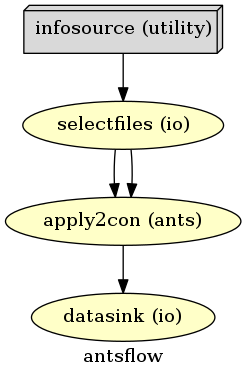

In [8]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph.png'))

##  Run the Workflow

Now that everything is ready, we can run the ANTs normalization workflow. 

In [9]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

200731-15:28:15,438 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
200731-15:28:15,467 nipype.workflow INFO:
	 Running in parallel.
200731-15:28:15,471 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 7 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
200731-15:28:15,549 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_subject_id_09/selectfiles".200731-15:28:15,550 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_subject_id_08/selectfiles".

200731-15:28:15,551 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_subject_id_07/selectfiles".200731-15:28:15,552 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_subject_id_05/selectfiles".

200731-15:28:15,560 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.int

	 sub: /output/datasink/norm_ants/_subject_id_08/_apply2con2/con_0003_trans.nii -> /output/datasink/norm_ants/sub-08/con_0003_trans.nii
200731-15:28:29,575 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_subject_id_08/_apply2con3/con_0004_trans.nii -> /output/datasink/norm_ants/sub-08/con_0004_trans.nii
200731-15:28:29,577 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_subject_id_08/_apply2con4/con_0005_trans.nii -> /output/datasink/norm_ants/sub-08/con_0005_trans.nii
200731-15:28:29,579 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_subject_id_08/_apply2con5/ess_0006_trans.nii -> /output/datasink/norm_ants/sub-08/_apply2con5/ess_0006_trans.nii
200731-15:28:29,584 nipype.workflow INFO:
	 [Node] Finished "antsflow.datasink".
200731-15:28:31,485 nipype.workflow INFO:
	 [Job 5] Completed (antsflow.datasink).
200731-15:28:31,490 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 23 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
2007

200731-15:28:45,501 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
200731-15:28:45,569 nipype.workflow INFO:
	 [Job 62] Cached (_apply2con5).
200731-15:28:45,569 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.datasink" in "/output/workingdir/antsflow/_subject_id_03/datasink".
200731-15:28:45,579 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
200731-15:28:45,583 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_subject_id_03/_apply2con0/con_0001_trans.nii -> /output/datasink/norm_ants/sub-03/con_0001_trans.nii
200731-15:28:45,585 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_subject_id_03/_apply2con1/con_0002_trans.nii -> /output/datasink/norm_ants/sub-03/con_0002_trans.nii
200731-15:28:45,587 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_subject_id_03/_apply2con2/con_0003_trans.nii -> /output/datasink/norm_ants/sub-03/con_0003_trans.ni

# Visualize Results


In [10]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
subject_id = '02'
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

First, let's chek the normalization of **anatomical** image:

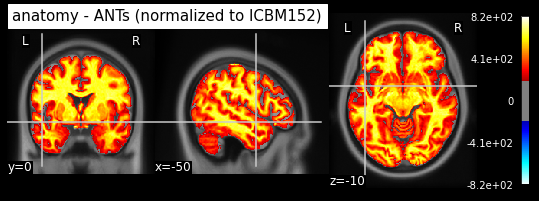

In [11]:
plot_stat_map(
   f'/data/ds000114/derivatives/fmriprep/sub-{subject_id}/anat/sub-{subject_id}_t1w_space-mni152nlin2009casym_preproc.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

And what about the **contrast** images for **Foot > others**?

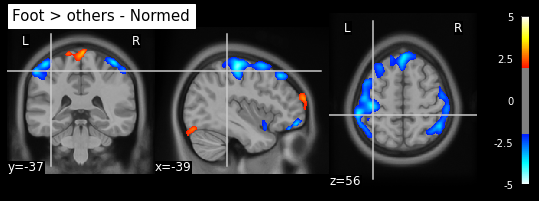

In [12]:
plot_stat_map(
    f'/output/datasink/norm_ants/sub-{subject_id}/con_0005_trans.nii', title='Foot > others - Normed',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56))

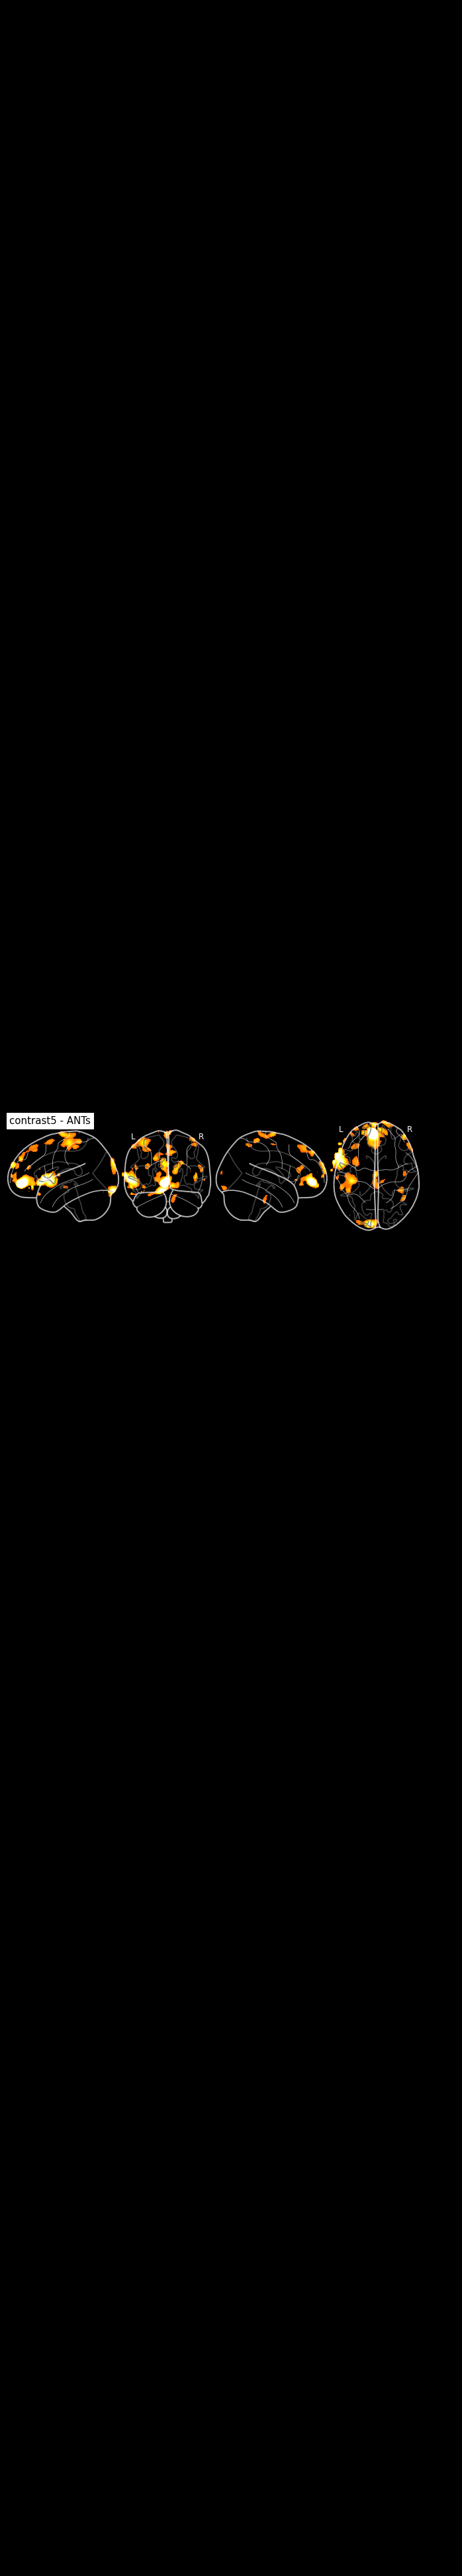

In [13]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    f'/output/datasink/norm_ants/sub-{subject_id}/con_0005_trans.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - ANTs')

# 2nd level analysis

After we normalized the subjects data into template space, we can now do the group analysis.

In [14]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'


# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005']

mask = "/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

In [15]:
!tree /output/datasink/2ndLevel

/output/datasink/2ndLevel
├── con_0001
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
├── con_0002
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
├── con_0003
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
├── con_0004
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
└── con_0005
    ├── con_0001.nii
    ├── SPM.mat
    ├── spmT_0001.nii
    └── spmT_0001_thr.nii

5 directories, 20 files


In [16]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts, we use fdr correction
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list)]

# SelectFiles - to grab the data
templates = {'cons': opj(output_dir, 'norm_ants', 'sub-*',
                         '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
datasink.inputs.substitutions = substitutions

In [17]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

In [18]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

200731-15:29:00,526 nipype.workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
200731-15:29:00,557 nipype.workflow INFO:
	 Running in parallel.
200731-15:29:00,561 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
200731-15:29:00,664 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/output/workingdir/ants_l2analysis/_contrast_id_con_0005/selectfiles".200731-15:29:00,665 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/output/workingdir/ants_l2analysis/_contrast_id_con_0004/selectfiles".
200731-15:29:00,666 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/output/workingdir/ants_l2analysis/_contrast_id_con_0003/selectfiles".

200731-15:29:00,675 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200731-15:29:00,675 nipype.workflow INFO:
	 [Node] 

	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002/con_0001.nii -> /output/datasink/2ndLevel/con_0002/con_0001.nii
200731-15:29:12,710 nipype.interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002/spmT_0001_thr.nii -> /output/datasink/2ndLevel/con_0002/spmT_0001_thr.nii
200731-15:29:12,714 nipype.workflow INFO:
	 [Node] Finished "ants_l2analysis.datasink".
200731-15:29:14,575 nipype.workflow INFO:
	 [Job 10] Completed (ants_l2analysis.datasink).
200731-15:29:14,578 nipype.workflow INFO:
	 [Job 15] Completed (ants_l2analysis.datasink).
200731-15:29:14,581 nipype.workflow INFO:
	 [Job 20] Completed (ants_l2analysis.datasink).
200731-15:29:14,583 nipype.workflow INFO:
	 [Job 25] Completed (ants_l2analysis.datasink).
200731-15:29:14,587 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
200731-15:29:14,678 nipype.workflow INFO:
	 [Job 26] Cached (ants_l2analysis.onesampttestdes).
200731-15:29:16,

In [19]:
#!nipypecli crash /home/neuro/nipype_tutorial/lection/crash-20200721-181746-neuro-selectfiles.a5-607b7489-d773-4d9c-ae69-49eca16a30d1.pklz


**Keep in mind, that the group analysis was only done on *`N=7`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **average**:

Let's take a look at the files we produced

In [20]:
!tree /output/datasink/2ndLevel

/output/datasink/2ndLevel
├── con_0001
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
├── con_0002
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
├── con_0003
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
├── con_0004
│   ├── con_0001.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0001_thr.nii
└── con_0005
    ├── con_0001.nii
    ├── SPM.mat
    ├── spmT_0001.nii
    └── spmT_0001_thr.nii

5 directories, 20 files


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


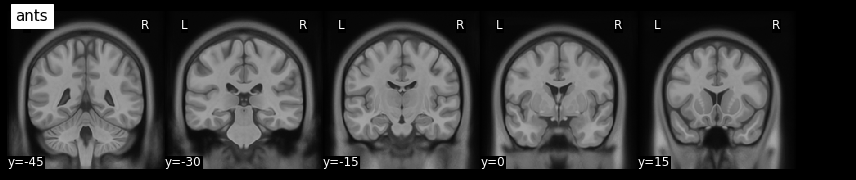

In [21]:
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'
plot_stat_map(
    '/output/datasink/2ndLevel/con_0001/spmT_0001_thr.nii', title='ants', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

Now, let's see other contrast **Foot > others**  using the glass brain plotting method.

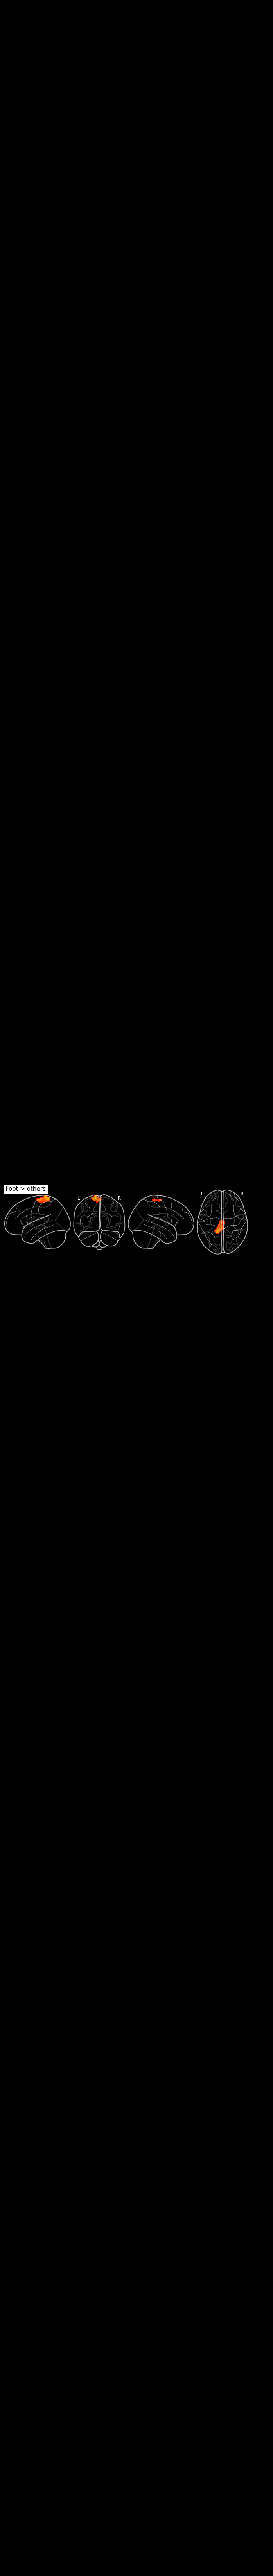

In [22]:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(
    '/output/datasink/2ndLevel/con_0005/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='Foot > others');


# Multiple comparison problem

When we make statistical maps we set a treshold at a given confidance level $\alpha$ and declare all voxels for which beta is above this  this leval as active.
Typically our  $H_0$ is that the voxel is not active.

![Hypothesis testing](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fnmeth.2698/MediaObjects/41592_2013_Article_BFnmeth2698_Fig1_HTML.jpg)

During fMRI experiments we peform test for each voxel, which means there will be many false active voxels.
There are many ways to deal with this problem.

**FWER (family-wize error rate) methoods**

We controll for any false positives $FP$:
$$FWER=P(FP \geq 1)$$
$H_0$ is that there is no activation in any of the $V$ voxels.

Control for type 1 errors(We wrongly have rejected the $H_0$). 
    

**Bonferoni correction**. The treshold is adjusted as $\alpha/V$.

Decresess too much the probability of correctly rejecting  $H_0$.
    
The voxels are not completly independent.

**Random field theory** estimates the number of independent statistical tests based upon the spatial correlation, or smoothness.

The number of independet comparisons for smoothed data is:
     $$V /FWHM^3 $$
     
where 
$FWHM$-full width at half maximum

 At a smoothness of 3 voxels, there would be 1 /27 as many independet comparisons. 
     
The Euler characteristic of the data give us estimation  how many clusters of activity should be found by chance at a given statistical threshold
    
    
FWER metoods often give too conservative treshold, oftetims FDR gives a better treshold.

**FDR (False discovery rate)**

Control for the false positives $FP$ among all declared positivies $P$.
$$FDR=E(FP/P)$$


Let's take a look how the popular **Benjamini and Hochberg** FDR procudure work.

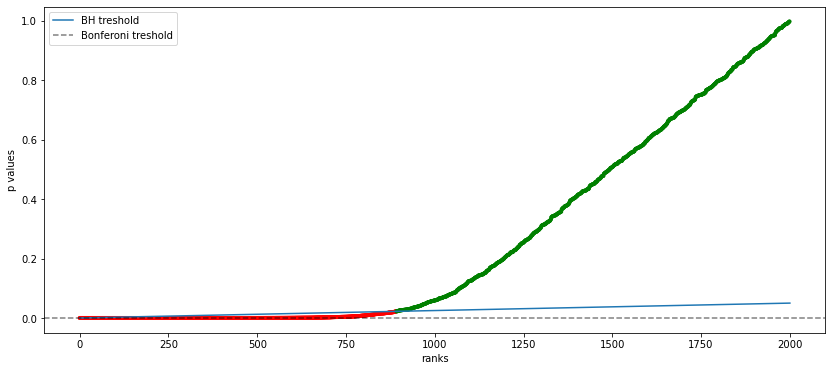

In [23]:
import numpy as np
np.random.seed(1)
#define a treshold level
level = 0.05
#here we simulate some data to work with
#how the treshold is affected by changing signal_to_noise? 
n_points = 2000
signal_to_noise = 0.5
noise = np.random.uniform(size=int(n_points*(1-signal_to_noise)))
#signal = np.random.uniform(size=int(n_points*signal_to_noise), high=0.001)
signal = np.random.beta(a=0.1,b=8, size=int(n_points*signal_to_noise))
pvals = np.concatenate([noise, signal])

#rank and sort the p values
pvals_sortind = np.argsort(pvals)
pvals_sorted = pvals[pvals_sortind]
n_samples = pvals.shape[0]

# the active points are the ones with: p_valule < (rank/n_samples)*level
above_tresh = (np.arange(1,n_samples+1)*level/n_samples>pvals_sorted)
positive = np.cumsum(above_tresh[::-1])[::-1] #declare positive all points with rank less then the last postive
#Let't plot the result
import matplotlib.pyplot as plt


cols = ['red' if p else 'green' for p in positive]
fig, ax = plt.subplots(figsize=(14,6))

ax.scatter(range(n_samples), pvals_sorted, c=cols, marker='.')
ax.set_xlabel('ranks')
ax.set_ylabel('p values')
#lets add Bonferoni treshold for comparison
ax.plot([0, n_samples],[0, level], label='BH treshold')#Benjamini and Hochberg
plt.axhline(y=level/n_samples, color='black', ls='dashed', alpha = 0.5, label='Bonferoni treshold')
_ = ax.legend()

To add thanks to ...